# Categorical Encoding Analisis
<div style="text-align: justify">
Como es bien sabido, la mayor parte de los algoritmos de machine learning funcionan de manera sobresaliente cuando las variables utilizadas para su entrenamiento son de tipo numerico. Sin embargo, el reto se presenta a la hora de incorporar variables cualitativas dado que son pocos los algoritmos que manejan de forma nativa atributos cualitativos. Esta situacion obliga a los cientificos de datos a buscar alternativas que puedan garantizar un correcto modelamiento y resultados en terminos de prediccion. Teniendo en cuenta lo anterior, el presente analisis busca evaluar el efecto de diferentes tecnicas de encoding de variables cualitativas sobre el performance de modelos de aprendizaje de maquina. 
<br/><br/>
En el primer apartado se describen los datos y las distintas tecnicas a utilizar durante todo el analisis. En segundo lugar, se analiza de forma estadistica los datos y se muestran distintos problemas que deben ser abordados mediante preprocesamiento. Cabe destacar que esta etapa no es el objetivo primario, por lo tanto, se aplicaran tecnicas que no requieran un alto nivel de complejidad. En ese orden de ideas, tampoco se aplicaran tecnicas complejas de seleccion de atributos (metodos de filtrado o wrapper), unicamente se permitiran aquellos metodos embebidos dentro de los modelos utilizados.
<br/><br/>
Posteriormente se analizan las distintas tecnicas de encoding en funcion de las variables que se encuentran dentro del dataset, sus ventajas y desventajas. Seguido se procede a crear el pipeline de preprocesamiento para finalmente entrenar y evaluar los modelos.

Conclusion
</div>

## 1. Descripcion del experimento y preparacion del enviroment
<div style="text-align: justify">
Los datos a utilizar seran los de la tabla *heart decease* que se encuentran dentro del repositorio de Machine learning de UC Irvine, los cuales pueden ser consultados en la pagina https://archive.ics.uci.edu/dataset/45/heart+disease. Esta investigacion busca determinar los factores asociados a enfermedades cardiacas en diferentes pacientes. Originalmente se utilizaron 76 variables para esta investigacion, sin embargo, solo se hicieron publicas 14 descritas a continuacion:

- age: edad
- sex: Genero (1 masculino, 0 femenino)
- cp: tipo de dolor de pecho (1 Agina tipico, 2 Angina atipico, 3 Dolor no anginal, 4 Asintomatico)
- trestbps: presion arterial en reposo
- chol: nivel de colesterol
- fbs: azucar en sangre mayor que 120 mg/dl (1 mayor que 120, 0 menor que 120)
- restecg: nivel de electrocardiograma en reposo (0 normal, 1 tiene una anomalia, 2 hipertrofia ventricular)
- thalach: maximo nivel de presion arterial alcanzado
- exang: angina inducida por ejercicio (1 Si, 0 No)
- oldpeak: Depresion ST inducida por el ejercicio relativo al descanso
- slope: Pendiente del maximo de ejercicio en el segmento ST (1 Creciente, 2 Plana, 3 Decreciente)
- ca: Numero maximo vessels coloreados en fluroscopia
- thal: 3 Normal, 5 defecto arreglado, 7 defecto reversible.
- num: variable respuesta

A continuacion se importan las librerias y los datos a utilizar del repositorio mencionado anteriormente

In [1]:
# Importando librerias
from ucimlrepo import fetch_ucirepo 
import polars as pl
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
import pandas as pd


In [2]:
# Configuracion de graficos
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.set(rc={"figure.figsize":(3, 3.5)})

In [182]:
# Importando data
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets.num
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [183]:
print(f"El numero de registros en los datos es {X.shape[0]}")

El numero de registros en los datos es 303


El dataset contiene aproximadamente 300 registros. Este es un numero relativamente pequeño de observaciones, por lo tanto no es recomendable utilizar una data de validacion para hacer tunning de hiperparametros. Este proceso se realizará haciendo cross-validation con 5 repeticiones para 5 folds.

## 2. Exploracion de los datos
<div style="text-align: justify">
En esta seccion se hara una breve exploracion de los datos elegidos para el analsis en terminos de calidad de datos. Para esto, se realizara de forma inmediata la division entre train y test (80%-20%) y de esa forma evitar cualqueir tipo de data leakage. Posteriormente, se verificara si existan datos faltantes, numero de niveles de variables categoricas, si existen datos atipicos y el tipo de atributos. Asimismo, se aplicaran otro tipo de tecnicas para determinar si existe redundancia entre variables

In [184]:
# Dividiendo en train y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=567)
Xtrain, Xtest = pl.from_pandas(Xtrain), pl.from_pandas(Xtest)
ytrain, ytest = pl.Series(ytrain), pl.Series(ytest)
Xtrain.head()

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,f64
59,1,4,110,239,0,2,142,1,1.2,2,1.0,7.0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
44,0,3,118,242,0,0,149,0,0.3,2,1.0,3.0
47,1,4,110,275,0,2,118,1,1.0,2,1.0,3.0
63,0,3,135,252,0,2,172,0,0.0,1,0.0,3.0


<div style="text-align: justify">
Luego de la division, los datos de entrenamiento reportan 242 registros mientras que los datos de prueba tienen 61. Ambos cuentan con el mismo numero de variables (13).
<br/><br/>
Por otro lado, se hace necesario explorar la variable respuesta

In [185]:
# Variable respuesta
ytrain.value_counts()

num,count
i64,u32
2,25
4,9
0,131
3,33
1,44


<div style="text-align: justify">
Se observa que la variable a predecir tiene 5 niveles, esto hace referencia a diferentes tipos de enfermedades cardiacas, sin embargo, se procederá a codificar dichas variables en solo 2 niveles: 0 no tiene enfermedad cardiaca, 1 tiene cualquier tipo de enfermedad. Esta codificacion se aplica tanto para la respuesta de entrenamiento como la de prueba

<Axes: xlabel='num', ylabel='count'>

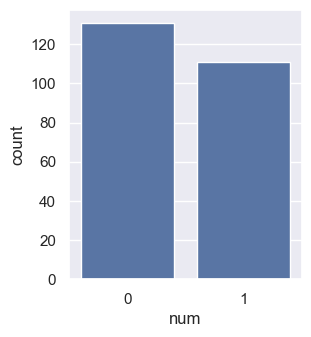

In [186]:
# Codificando nueva respuesta
ytrain = ytrain.replace([0, 1, 2, 3, 4], [0, 1, 1, 1, 1])
ytest = ytest.replace([0, 1, 2, 3, 4], [0, 1, 1, 1, 1])
sns.barplot(data=ytrain.value_counts().lazy().collect(), x='num', y='count')

<div style="text-align: justify">
Luego del cambio en la codificacion se puede observar que los datos de la variable respuesta estan distribuidos de forma relativamente igual, por lo tanto no se hara necesario usar ningun metodo de balanceo.

<Axes: >

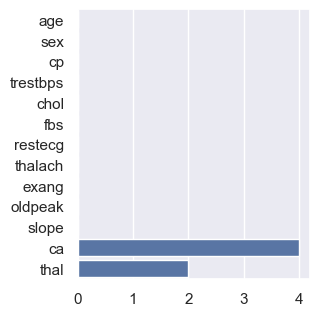

In [187]:
# Describiendo data
missingValues = Xtrain.select(pl.all().is_null().sum())
sns.barplot(y=missingValues.columns, x=missingValues[0].to_numpy().reshape((-1, )))

<div style="text-align: justify">
En primer lugar, se observa que las variables CA y Thal contienen valores faltantes, sin embargo, es un numero reducido de registros con esta caracteristica. A pesar de esto, se debe realizar algun metodo de imputacion.

In [188]:
# Valores unicos
Xtrain.select(pl.all().n_unique())

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
40,2,4,46,135,2,3,87,2,38,3,5,4


<div style="text-align: justify">
Se observa que las variables Sex, CP, fbs, restecg, exang, slope y Thal tienen pocos valores unicos, es decir, podriamos asociarlas a variables cualitativas. En el caso de la variable CA la documentacion de la fuente de informacion indica que esta es una variable discreta, por lo tanto aunque tenga pocos valores unicos se mantendra como tal.

In [189]:
# Definiendo tipos de variables
catCols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numCols = [i for i in Xtrain.columns if i not in catCols]
print("Numeric variables:", numCols)
print("Categorical variables:", catCols)

Numeric variables: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
Categorical variables: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [190]:
# Cambiando tipo de variables
Xtrain = Xtrain.with_columns(pl.col(catCols).map_elements(str))
Xtest = Xtest.with_columns(pl.col(catCols).map_elements(str))
Xtest.head()

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
i64,str,str,i64,i64,str,str,i64,str,f64,str,f64,str
54,"""1""","""4""",124,266,"""0""","""2""",109,"""1""",2.2,"""2""",1.0,"""7.0"""
55,"""0""","""4""",180,327,"""0""","""1""",117,"""1""",3.4,"""2""",0.0,"""3.0"""
43,"""1""","""4""",150,247,"""0""","""0""",171,"""0""",1.5,"""1""",0.0,"""3.0"""
51,"""1""","""3""",125,245,"""1""","""2""",166,"""0""",2.4,"""2""",0.0,"""3.0"""
77,"""1""","""4""",125,304,"""0""","""2""",162,"""1""",0.0,"""1""",3.0,"""3.0"""


<div style="text-align: justify">
Otra dimension dentro del preprocesamiento es el tratamiento de datos atipicos. Esto se aplica principalmente para las variables cuantitativas definidas anteriormente. Para ello, se analizaran mediante graficos de cajas y bigotes donde cada punto atipico se encuentra a cierta distancia del rango intercuartilico (RIC).

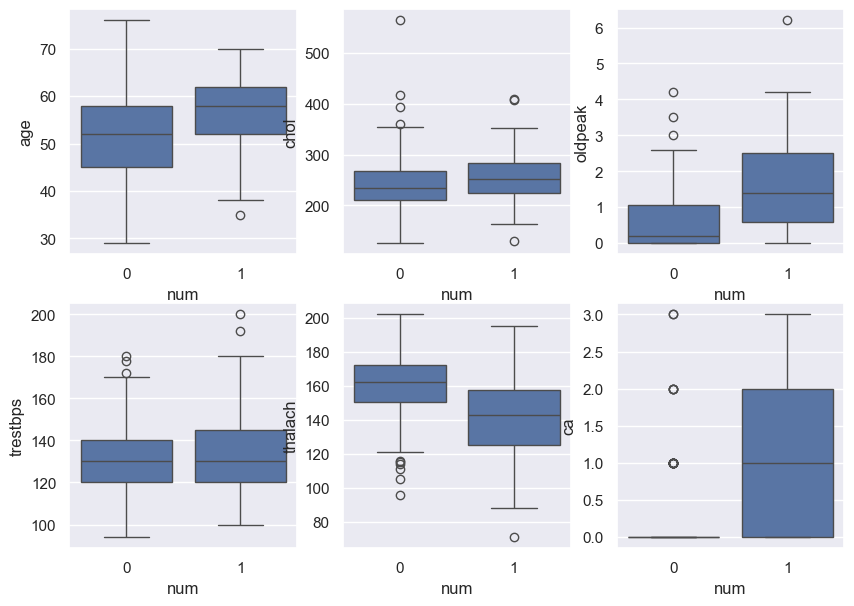

In [191]:
# atipicos
ncol=3
nrow=2
contador = 0
fig, axs = plt.subplots(ncols=ncol, nrows=nrow,figsize=(10, 7))
for i in range(ncol):
    for j in range(nrow):
        col=numCols[contador]
        sns.boxplot(data=Xtrain.lazy().collect(), x=ytrain, y=col, ax=axs[j, i])
        contador += 1
        if contador == 6:
            break

<div style="text-align: justify">
Al analizar las variables cuantitativas resalta que se encuentran en distinta escala, por ejemplo, la variable edad oscila entre 30 y 70 mientras que la variable oldpeak oscila entre 0 y 6 aproximadamente. Otro aspecto a destacar es el hecho que todas presentan valores atipicos, algunas en mayor manera que otras. Teniendo en cuenta lo anterior, se debe realizar algun proceso para suavizar estos datos como por ejemplo, aplicar logarimo natural a cada una de ellas
<br/><br/>
Finalmente, algo que puede tener efecto sobre la etapa de modelamiento son las correlaciones entre variables. Para el caso de las cuantitativas, se utiliza el metodo de correlacion de pearson para determinar la asociacion lineal entre ellas.

In [194]:
# Correlaciones variables numericas
Xtrain.select(numCols).drop_nulls().corr()

age,trestbps,chol,thalach,oldpeak,ca
f64,f64,f64,f64,f64,f64
1.0,0.326093,0.231286,-0.442846,0.217457,0.376634
0.326093,1.0,0.114614,-0.04236,0.175465,0.086733
0.231286,0.114614,1.0,0.005292,0.02457,0.120898
-0.442846,-0.04236,0.005292,1.0,-0.322046,-0.332063
0.217457,0.175465,0.02457,-0.322046,1.0,0.336587
0.376634,0.086733,0.120898,-0.332063,0.336587,1.0


<div style="text-align: justify">
Al calcular el indice de Pearson se observa que unicamente las variables edad y thalach tienen una correlacion negativa superior al 30%. Aun asi, este valor no es suficiente como para asumir que existe multicolinealidad y que esto podra afectar el modelo en su etapa de entrenamiento.
<br/><br/>
En el caso de las variables cualitativas, se procede a utilizar el test de dependencia de chi2, el cual compara las probabildiades esperadas con las observadas de cada combinacion de niveles de los atributos y mira si hay algun valor mayor o menor de lo esperado. Esta prueba no muestra como tal una correlacion, pero si muestra una dependencia entre los atributos analizados cuando se rechaza la hipotesis nula (valor P menor que 0.05)

In [195]:
# Correlaciones cualitativas
for i in range(len(catCols)):
    for j in range(len(catCols)):
        var1 = catCols[i]
        var2 = catCols[j]
        pvalue = chi2_contingency(pd.crosstab(Xtrain[var1], Xtrain[var2]))[1]
        if (pvalue < 0.05) & (var1 != var2):
            print(f"variable {var1} and {var2} show dependency with a pvalue {pvalue}")

variable sex and cp show dependency with a pvalue 0.04262963665545424
variable sex and exang show dependency with a pvalue 0.014263788397086048
variable sex and thal show dependency with a pvalue 3.734052473306374e-08
variable cp and sex show dependency with a pvalue 0.04262963665545424
variable cp and exang show dependency with a pvalue 8.869200430808388e-13
variable cp and slope show dependency with a pvalue 0.0005609846444478059
variable cp and thal show dependency with a pvalue 1.1347932129509136e-05
variable fbs and slope show dependency with a pvalue 0.037922315565965474
variable exang and sex show dependency with a pvalue 0.014263788397085992
variable exang and cp show dependency with a pvalue 8.869200430808388e-13
variable exang and slope show dependency with a pvalue 4.003519325761956e-05
variable exang and thal show dependency with a pvalue 2.97859430351113e-06
variable slope and cp show dependency with a pvalue 0.0005609846444478053
variable slope and fbs show dependency wit

<div style="text-align: justify">

Al analizar las variables cualitativas se muestra que la unica variable que no presenta dependencia con alguna otra es *restecg*. El hecho de que todas las variables restantes muestren cierta asociacion entre ellas indica que se debe tener cuidado a la hora de seleccionar el metodo de encoding.
<br/><br/>
Como conclusion del analisis descriptivo se puede decir lo siguiente:

- Existen datos faltantes principalmente para variables cualitativas, por lo tanto, **se debe realizar algun tipo de imputacion por moda**
- Las variables cualitativas se encuentran en distinta escala, por lo tanto **se debe hacer algun tipo de estandarizacion dependiendo del algoritmo a utilizar**.
- Existen datos atipicos, por lo tanto **se deben suavizar con alguna transfomacion como logaritmo natural**
- Existen dependencias entre las variables cualitativas, por lo tanto **se debe tener cuidado a la hora de seleccionar el metodo de encoding**. 

## 3. Definicion de metodos de Encoding
<div style="text-align: justify">

Tal como se mencionó anteriormente, el objetivo de este analisis es el aplicar distintos metodos para codificar variables cualitativas y de esa forma determinar su impacto sobre el performance de modelos de ML. En esta seccion del analisis se describen algunos encoding, sus ventajas y desventajas.
<br/><br/>
En segundo lugar, se analizará el tipo de variable cualitativa, es decir, si pertenecen al grupo de variables cualitativas ordinales y nominales. Teniendo en cuenta tal clasificacion, se resume cual o cuales de los metodos de encoding aplicaria a cada una de las variables.
<br/><br/>
La data que se utilizará para testear cada uno de los encoding se muestra a continuacion:

In [58]:
# Data testeo
dicVar = {'Variable1': [1, 2, 3, 1, 5, 6, 7, 9, 10, 2, 3, 4, 1, 2, 2, 2, 3, 5, 1, 4],
          'Variable2': ['A', 'B', 'B', 'B', 'C', 'A', 'B', 'A', 'C', 'B', 'A', 'B', 'B', 'A', 'C', 'B', 'B', 'A', 'B' ,'C']}
EncodingX = pl.DataFrame(dicVar)
EncodingY = pl.Series('y', [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])
EncodingX.head()

Variable1,Variable2
i64,str
1,"""A"""
2,"""B"""
3,"""B"""
1,"""B"""
5,"""C"""


### 3.1.1. Tipos de encoding
<div style="text-align: justify">
En este primer apartado se procede a explicar los distintos encoders a utilizar. Dentro de la literatura existen muchas alternativas para manejar datos categoricos, sin embargo, a continuacion se presentan algunos de los mas utilizados dentro de la comunidad de cientificos de datos

#### 3.1.1.1 Ordinal Encoder
<div style="text-align: justify">

El primer encoder a considerar es el **ordinal encoder**, este consiste en asignar un valor numerico a cada uno de los niveles de la variable categorica tal como se muestra a continuacion:

In [65]:
# Ordinal Encoder
from sklearn.preprocessing import OrdinalEncoder
OrdinalE = OrdinalEncoder()
varEncoded = OrdinalE.fit_transform(EncodingX.select('Variable2'))
EncodingX.with_columns(pl.Series('Variable2Encoded', varEncoded.reshape(-1, ))).head()

Variable1,Variable2,Variable2Encoded
i64,str,f64
1,"""A""",0.0
2,"""B""",1.0
3,"""B""",1.0
1,"""B""",1.0
5,"""C""",2.0


<div style="text-align: justify">
Se puede observar que el encoder asigno el valor de 0 a la categoria A, el valor de 1 a la categoria B y el valor de 2 a la categoria C. La principal ventaja de esta codificacion es su aplicabilidad para variables cualitativas ordinales, es decir, aquellas en donde el orden de los niveles signifique algo. Por ejemplo, para el caso del nivel de estudios (bachiller, pregrado o postgrado), el modelo será capaz de capturar la informacion referente al hecho de que bachiller es menor que pregrado a su vez, que pregrado es menor que postgrado. 
<br/><br/>
Por otro lado, una desventaja de este tipo de codificacion es aplicarlo a variables cualitativas de tipo nominal, donde no haya ninguna evidencia sobre el significado del orden de los niveles. Por ejemplo, en el caso del genero no tendria sentido aplicar esta transformacion

#### 3.1.1.2 Encoder por frecuencia
<div style="text-align: justify">

En segundo lugar esta el **encoder por frecuencia**, el cual consiste en calcular la frecuencia de ocurrencia de cada nivel de la variable categorica y asignarlo como su respectiva codificacion. Un ejemplo de esto se muestra a continuacion:

In [66]:
# Freq Encoder
FreqEncoder = EncodingX['Variable2'].value_counts().to_dict(as_series=False)
print(FreqEncoder)
EncodingX.with_columns(pl.col('Variable2').replace(FreqEncoder['Variable2'],
                                                   FreqEncoder['count']).cast(pl.Int32).alias('Variable2Encoded')).head()

{'Variable2': ['B', 'C', 'A'], 'count': [10, 4, 6]}


Variable1,Variable2,Variable2Encoded
i64,str,i32
1,"""A""",6
2,"""B""",10
3,"""B""",10
1,"""B""",10
5,"""C""",4


<div style="text-align: justify">

Tal como se muestra en la tabla anterior, los niveles A, B y C recibirian la codificacion de 6, 10 y 4 respectivamente dado que es su frecuencia de ocurrencia en el dataset, lo cual puede ser ventajoso cuando el problema a predecir se explica por este tipo de comportamientos. Por ejemplo, en el caso de analisis de sentimientos, es muy probable que un escrito que tenga un alto numero de palabras positivas (bueno, excelente, explendido) y un muy bajo numero de palabras negativas (malo, triste, pesimo) haya sido escrito por alguien con una intension positiva.
<br/><br/>
Por otro lado, este tipo de codificacion no es apropiada si existen varios niveles de la variable con el mismo numero de ocurrencias dentro de los datos. En este caso, el modelo asumira que estas categorias son iguales, lo que alterará los resultados tanto a la hora de hacer feature selection como a la hora de entrenar el modelo.

#### 3.1.1.3 One Hot Encoder
<div style="text-align: justify">

En tercer lugar se encuentra el **One Hot Encoder**. Este es un tipo de encoding muy popular dentro de los algoritmos de ML, el cual crea una variable dummy para cada nivel de la variable cualitativa, indicando la presencia (1) o ausencia (0) del atributo para cada registro de la tabla. Un ejemplo de esto se muestra a continuacion:

In [83]:
#OHE
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder()
varEncoded = OHE.fit_transform(EncodingX.select('Variable2')).toarray()
varEncoded = pl.from_numpy(varEncoded, schema=OHE.get_feature_names_out().tolist())
pl.concat([EncodingX, varEncoded], how='horizontal').head()

Variable1,Variable2,Variable2_A,Variable2_B,Variable2_C
i64,str,f64,f64,f64
1,"""A""",1.0,0.0,0.0
2,"""B""",0.0,1.0,0.0
3,"""B""",0.0,1.0,0.0
1,"""B""",0.0,1.0,0.0
5,"""C""",0.0,0.0,1.0


<div style="text-align: justify">

Como se muestra en la tabla anterior se añadieron 3 nuevas columnas: una para cada nivel de la variable cualitativa y cada una de esas columnas toma el valor de 1 para el nivel que se encuentra en la variable original. Esto es ideal para cualidades cuyo orden no tenga un significado para el problema de prediccion, por ejemplo, el color de los ojos de una persona. Otro aspecto importante es que se debe usar para variables que tengan pocos niveles.
<br/><br/>
De hecho, el ultimo aspecto mencionado es una de las principales desventajas de este encoding: aplicar esta tecnica en una variable que tenga muchos niveles puede generar muchas columnas. Lo anterior crea una matriz **sparse** la cual es ineficiente para los algoritmos en materia de calculo computacional. Una posible solucion para este problema es la agrupacion de categorias menos frecuentes en una unica categoria que generalmente se encuentra como **otros**. Esta alternativa disminuiria la dimensionalidad de los datos luego de aplicar OHE haciendo mas eficiente el modelamiento.
<br/><br/>
La estrategia anterior puede ser contraproducente en algunos casos. Por ejemplo, si se intenta predecir la demanda de ciertos productos con base en sus ventas pasadas, se podria agrupar en una sola categoria aquellos con baja demanda. Sin embargo, si se produce un nuevo producto lo mas probable es que este tenga una baja demanda por no tener mucho tiempo en el mercado, por lo tanto, aunque en el futuro este tenga ventas considerablemente altas, siempre quedara categorizado en el grupo de otros.

#### 3.1.1.4 Target Encoder
<div style="text-align: justify">

En el cuarto lugar se encuentra el **Targer Encoder**, tambien conocido como **Mean Encoder**.  Este es un tipo de encoding bastante polemico debido a que utiliza la variable respuesta para asignar la codificacion numerica. Basicamente asigna el promedio de los valores de la variable respuesta que pertenecen a cada categoria dentro de los datos de entrenamiento. A continuacion se muestran la media de la variable respuesta teniendo en cuenta cada categoria de la variable2:

In [101]:
# Medias
EncodingX.with_columns(pl.Series(EncodingY)).group_by('Variable2').agg(pl.col('y').mean()).rename({'y': 'media'})

Variable2,media
str,f64
"""B""",0.3
"""A""",0.5
"""C""",0.5


<div style="text-align: justify">

El resultado anterior pasaria a ser el encoding de cada valor de la variable2, sin embargo, esto tiene un problema y es el overfit principalmente porque estariamos calculando promedios sobre muy pocos valores lo cual implica que las medias en un posible dataset de prueba podrian ser muy distintas a las reportadas en entrenamiento. Teniendo en cuenta lo anterior, una solucion usada es incorporar la media de toda la variable respuesta de la sigueinte forma:
<br/><br/>
$$ encoding_i =  \frac{n\overline{x} + mw}{n + m}$$
<br/><br/>
Donde $n$ es el numero de observaciones que pertenecen a un nivel de una categoria (observaciones donde Variable2 = "A" por ejemplo), $\overline{x}$ es el promedio de la variable respuesta para esas observaciones, $w$ es el promedio total de la variable respuesta dentro del dataset y $m$ es un valor definido por el usuario para determinar cuanto queremos que pese el promedio general sobre el encoding. En caso que asignemos ese peso con el valor de 0, el encoding sera exactamente la media, coincidiendo con los valores de la tabla anterior. Si el valor de $m$ es muy grande, el encoding tendera a tomar valores muy similares a la media general. 

In [112]:
# Target Encoder
from sklearn.preprocessing import TargetEncoder
TargetE = TargetEncoder()
TargetE.fit(EncodingX.select('Variable2'), EncodingY)
TargetE.transform(EncodingX.select('Variable2'))
varEncoded = TargetE.transform(EncodingX.select('Variable2'))
EncodingX.with_columns(pl.Series('Variable2Encoded', varEncoded.reshape(-1, ))).head()

Variable1,Variable2,Variable2Encoded
i64,str,f64
1,"""A""",0.485207
2,"""B""",0.308046
3,"""B""",0.308046
1,"""B""",0.308046
5,"""C""",0.479339


<div style="text-align: justify">

La libreria sklearn puede aplicar este encoding aplicando tecnicas bayesianas para calcular el valor del peso de la media general. Aplicar este metodo basicamente asigna un valor relacionado a cuantas veces ha sucedido el evento de estudio en el pasado para esa categoria especifica, asimismo es aplicable para variables con gran cantidad de categorias sin importar si el problema de prediccion es regresion o clasificacion (binaria o multiple). 
<br/><br/>
Otro aspecto a tener en cuenta es el posible data leakage dado que se esta utilizando la media global de la variable respuesta. Para controlar este aspecto, SKLearn incorpora cross validation mediante el metodo `fit_transform`. Cabe resaltar que hacer el encoding usando `fit` y luego `transform` no utilizara el cross validation, por lo tanto se podria estar generando leakage. 

In [176]:
# Target Encoder
from sklearn.preprocessing import TargetEncoder
TargetE = TargetEncoder()
varEncoded = TargetE.fit_transform(EncodingX.select('Variable2'), EncodingY)
EncodingX.with_columns(pl.Series('Variable2Encoded', varEncoded.reshape(-1, ))).head()

Variable1,Variable2,Variable2Encoded
i64,str,f64
1,"""A""",0.39575
2,"""B""",0.375
3,"""B""",0.266304
1,"""B""",0.295592
5,"""C""",0.34334


Este metodo no es recomendable si existe cierta correlacion entre variables regresoras y la variable respuesta, asimismo tampoco es recomendable si la relacion (promedio) que existe entre una categoria y la variable respuesta cambia constantemente en el tiempo.

#### 3.1.1.5 Peso de evidencia Encoder
<div style="text-align: justify">

En ultimo lugar se encuentra el **Weigh of evidence Encoder (WoE)**. Este es un tipo de encoding bastante similar al target encoding dado que tambien utiliza la variable respuesta para asignar la codificacion a cada nivel de la variable categorica. La diferencia radica en la formulacion matematica dado que este encoder uitiliza el log ratio de la variable respuesta teniendo en cuenta el nivel categorico a codificar:
<br/><br/>
$$ encoding_i =  ln\frac{p(y=1)}{p(y=0)}$$
<br/><br/>
Donde $p(y=1)$ es la probabilidad de una observacion que pertenecen a un nivel de una categoria (observaciones donde Variable2 = "A" por ejemplo) tenga un valor de 1 en la variable respuesta, $p(y=0)$ es la probabilidad de una observacion que pertenecen a un nivel de una categoria tenga un valor de 0 en la variable respuesta.

In [174]:
# WoE encoder
total1 = EncodingY.sum()
total0 = len(EncodingY) - total1
EncodingX.with_columns(pl.Series(EncodingY)).\
    group_by('Variable2').agg(pl.col('y').sum().alias('y=1'),
                              pl.col('y').count().alias('Total')).\
                                with_columns((pl.col('Total') - pl.col('y=1')).alias('y=0')).\
                                    with_columns((pl.col('y=1')/total1).alias('Py=1'),
                                                 (pl.col('y=0')/total0).alias('Py=0')).\
                                                    with_columns(np.log(pl.col('Py=1')/pl.col('Py=0')).alias('WoE'))

Variable2,y=1,Total,y=0,Py=1,Py=0,WoE
str,i64,u32,i64,f64,f64,f64
"""B""",3,10,7,0.375,0.583333,-0.441833
"""C""",2,4,2,0.25,0.166667,0.405465
"""A""",3,6,3,0.375,0.25,0.405465


<div style="text-align: justify">
La tabla anterior muestra el calculo manual del WoE para cada nivel de variable2. Se muestra que para las categorias A y C su encoding seria positivo, esto indica que una observacion que tenga la categoria A o C tiene mayor probabilidad de pertenecer a la categoria 1. Por otro lado, en el caso de la categoria B, se muestra que su encoding seria -0.44, es decir, una observacion cuyo valor en variable2 sea B, tiene mayor probabilidad de pertenecer a la categoria 0 de la variable respuesta.
<br/><br/>
Esto es muy similar a lo que realiza la regresion logistica, por lo tanto este encoder es ideal para ese tipo de modelos. Adicionalmente, este metodo es muy util para variables cualitativas no ordinales.
<br/><br/>
Por otro lado, al igual que el metodo anterior, se hace necesario utilizar cross validatation dado que se esta generando el encoding basado en la variable respuesta. Otro aspecto negativo es el hecho de que no es recomendable utilizarlo con categorias ordinales dado que se pierde informacion

In [175]:
# WoE encoder
import category_encoders as ce
WOEEncoder = ce.WOEEncoder(cols='Variable2')
WOEEncoder.fit(EncodingX.to_pandas(), EncodingY.to_pandas())
varEncoded = WOEEncoder.transform(EncodingX.to_pandas()).add_suffix('Encoded')['Variable2Encoded']
EncodingX.with_columns(pl.Series(varEncoded)).head()

Variable1,Variable2,Variable2Encoded
i64,str,f64
1,"""A""",0.336472
2,"""B""",-0.356675
3,"""B""",-0.356675
1,"""B""",-0.356675
5,"""C""",0.336472


<div style="text-align: justify">
Al utilizar el WoE encoder de la libreria category encoders, se observa que los resultados son distintos a los calculados previamente, esto debido a que esta libreria incorpora un parametro de regularizacion (por defecto es 1) y un parametro de desviacion estandar (por defecto 0.05) para controlar el overfit que se puede generar al utilizar la variable respuesta dentro de este encoding

### 3.1.2. Descripcion de variables cualitativas
<div style="text-align: justify">

En este apartado se procede a analizar las variables cualitativas y determinar cual de los tipos de encoding vistos anteriormente seria posible aplicar a partir de sus ventajas y desventajas. Cabe resaltar que actualmente todas las variables cualitativas se encuentran codificadas de forma ordinal (ordinal encoder), sin embargo, se debe evaluar si existe otra forma que pueda aportar mejor rendimiento al modelo.
<br/><br/>
| Variable | encoder actual | valores actuales                                                                  | Encoders sugeridos                |
|----------|----------------|-----------------------------------------------------------------------------------|-----------------------------------|
| sex      | OHE            | 0: Femenino<br>1: Masculino                                                       | 1. Target <br>2. WoE              |
| cp       | Ordinal        | 1: Anginal tipico<br>2: Anginal atipico<br>3: Dolor no anginal<br>4: Asintomatico | 1. One hot|
| fbs      | OHE            | 1: Mayor a 120 mg/dl<br>0: menor a 120 mg/dl                                      | NA                                |
| restecg  | Ordinal        | 0: normal<br>1: Anomalia<br>2: Hipertrofia ventricular                            | 1. One hot|
| exang    | OHE            | 1: Si<br>0: No                                                                    | 1. Target<br>2. WoE                                 |
| slope    | Ordinal        | 1: Creciente<br>2: Plana<br>3: Decreciente                                        | 1. Ordinal<br>2. One hot          |
| thal     | Ordinal        | 3: Normal<br>4: Defecto arreglado<br>7: defecto reversible                        | 1. One hot                        |


<div style="text-align: justify">
Teniendo en cuenta la tabla anterior, se observa que las variables sex y exang son variables codificadas como OHE eliminando la segunda variable, alternativas para estas dos son TE y WoE debido a que no son variables ordinales. En el caso de fbs que tambien es una variable OHE se sugiere dejarlo de la forma original dado que parece una variable ordinal.
<br/><br/>
Para el resto de variables que han sido codificadas de forma ordinal se sugiere unicamente aplicar OHE dado que es un encoding que permite mantener el orden de las mismas.

## 4. Creacion de pipeline y entrenamiento de modelos
<div style="text-align: justify">

Teniendo en cuenta los resultados del analisis donde se describe la data, se concluyo que se deben realizar distintas tareas de preprocesamiento para entrenar los modelos. Por lo anterior, se utilizaran los pipelines de sklearn junto a las funciones de imputacion, estandarizacion de variables, suavizamiento de atipicos y encoding de variables cualitativas.
<br/><br/>
Asimismo, la tuberia se utilizara junto a validacion cruzada (cross-validation) para confirmar los resultados con distintas muestras y no utilizar una data de validacion.
<br/><br/>
Con respecto a los modelos, se utilizan

In [342]:
# Librerias para el pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report

<div style="text-align: justify">

Para crear el pipeline, se procede a dividir las operaciones de acuerdo con el tipo de variable, es decir, para las variables numericas se realizan ciertas operaciones y para las variables categoricas otras distintas. Por ejemplo, para el primer grupo se realiza lo siguiente:
1. Imputacion de datos faltantes
2. Suavizamiento de atipicos.

Dado que estos pasos son secuenciales y se aplican para todos los datos numericos, se debe utilizar la funcion `Pipeline`,sin embargo, por el momento se procede a ignorar el segundo paso.

In [334]:
# Pipeline variables numericas
numPL = Pipeline([('imputing', SimpleImputer(strategy='most_frequent')),
                  ('Scaling', StandardScaler())])
#numPL = Pipeline([('imputing', SimpleImputer(strategy='most_frequent'))])
numPL

Pipeline(steps=[('imputing', SimpleImputer(strategy='most_frequent')),
                ('Scaling', StandardScaler())])

<div style="text-align: justify">

Para el caso de las variables categoricas se debe hacer una operacion de imputacion por moda para la columna thal. Posterior a eso, se debe realizar el encoding. Este ultimo no es secuencial, es decir, se debe aplicar al mismo tiempo los distintos encodings definidos a previamente especificamente a ciertas columnas. Teniendo encuenta esto, se debe utilizar un pipeline para definir el paso de imputacion y luego el encoding, sin embargo, como las operaciones de encoding se deben hacer al mismo tiempo, se utiliza el metodo `ColumnTransformers` donde se puede especificar cada operacion en funcion de cada columna:

In [335]:
catPL = Pipeline([('imputing', SimpleImputer(strategy='most_frequent')),
                  ('Encoding', ColumnTransformer([('OHE', OneHotEncoder(), [1, 3, 6]),
                                                  ('TE', TargetEncoder(), [0, 4])], remainder='passthrough'))])
catPL

Pipeline(steps=[('imputing', SimpleImputer(strategy='most_frequent')),
                ('Encoding',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE', OneHotEncoder(),
                                                  [1, 3, 6]),
                                                 ('TE', TargetEncoder(),
                                                  [0, 4])]))])

<div style="text-align: justify">
Se observa que el pipeline primero imputara por moda cualquier valor faltante dentro de las variables categoricas, luego pasa al paso de encoding el cual es un column transformer donde aplica para algunas columnas un OHE y para otras un TE de acuerdo con lo definido anteriormente. 
<br/><br/>
Se especifican las variables de acuerdo con su posicion del dataset dado que al aplicar el imputer, este convierte los datos en un arreglo de numpy (sin nombre de columnas). La numeracion inicia desde cero dado que unicamente estos procesos se procederan a aplicar para las variables cualitativas.
<br/><br/>
Seguidamente, se deben unir los dos pipelines creados para las variables numericas y cualitativas. Esto se podria hacer con un pipeline, sin embargo, esto requeriria que primero se haga un grupo de operaciones y luego las segundas (por ejemplo, primero numericas y posteriormente categoricas), lo cual no es correcto. Ambas operaciones se deben hacer al mismo tiempo, por lo tanto se utiliza el column transformer:

In [336]:
ct = ColumnTransformer(transformers=[('numTrans', numPL, numCols),
                                     ('catTrans', catPL, catCols)])
ct

ColumnTransformer(transformers=[('numTrans',
                                 Pipeline(steps=[('imputing',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('Scaling',
                                                  StandardScaler())]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak', 'ca']),
                                ('catTrans',
                                 Pipeline(steps=[('imputing',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('Encoding',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('OHE',
                                                                                   OneHotEncoder(),
                                                                                   [1,
                                                                                    3,
                                                                                    6]),
                                                                                  ('TE',
                                                                                   TargetEncoder(),
                                                                                   [0,
                                                                                    4])]))]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                  'slope', 'thal'])])

In [366]:
from sklearn.model_selection import GridSearchCV
generalPL = Pipeline([('individualPreprocess', ct),
                      #('joinedScaling', StandardScaler()),
                      ('model', SVC())])
generalPL

Pipeline(steps=[('individualPreprocess',
                 ColumnTransformer(transformers=[('numTrans',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'ca']),
                                                 ('catTrans',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Encoding',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('OHE',
                                                                                                    OneHotEncoder(),
                                                                                                    [1,
                                                                                                     3,
                                                                                                     6]),
                                                                                                   ('TE',
                                                                                                    TargetEncoder(),
                                                                                                    [0,
                                                                                                     4])]))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'thal'])])),
                ('model', SVC())])